In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smart-farming-sensor-data-for-yield-prediction/Smart_Farming_Crop_Yield_2024.csv
/kaggle/input/geo-referenced-crop-prediction-dataset/model.ipynb
/kaggle/input/geo-referenced-crop-prediction-dataset/CropDataset-Enhanced.csv
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Recommender/app.py
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Recommender/.env.sample
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Recommender/model_trail.ipynb
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Recommender/CropDataset-Enhanced.csv
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Recommender/models/crop_multilabel_binarizer.pkl
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Recommender/models/soil_prediction_models.pkl
/kaggle/input/geo-referenced-crop-prediction-dataset/Crop Recommender (1)/Crop Reco

📥 Loading datasets...
✅ Datasets loaded successfully!
🔄 Merged dataset shape: (255, 22)
🧩 Derived features added: total 24 columns
✅ Selected top 23 predictive features
🚀 Training models...

🚜 Training Gaussian Process (Matérn)...


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: Converg


🚜 Training Random Forest...

🚜 Training XGBoost...

🚜 Training Neural Net...

🚜 Training Stacking Ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_proce


📊 Model Performance Summary:
                       Model  Train R²   Test R²     CV R²         MAE  \
4          Stacking Ensemble  0.988247  0.979345  0.977222  121.835869   
0  Gaussian Process (Matérn)  0.983684  0.969162  0.966700  161.084706   
1              Random Forest  0.983947  0.947260  0.957175  210.408811   
2                    XGBoost  1.000000  0.928703  0.932526  255.544199   
3                 Neural Net  0.939478  0.599597 -0.429446  636.943573   

             MSE  
4   29911.425744  
0   44658.204296  
1   76374.245499  
2  103248.620893  
3  579840.438580  


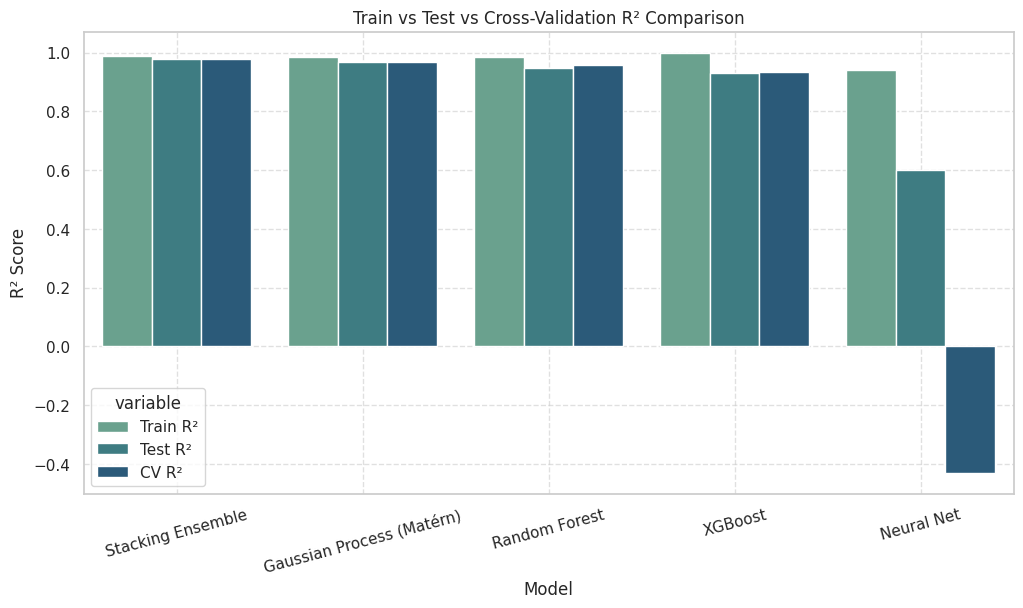

🌍 Generating yield map...



✅ Completed! Models trained and evaluated with overfitting control.


In [49]:
# ================================================================
# 🌾 Smart Farming Yield Prediction | GPR (Matérn) + Ensemble + Overfit Prevention
# ================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings("ignore")

print("📥 Loading datasets...")

# ================================================================
# Load datasets (Kaggle paths)
# ================================================================
crop_df = pd.read_csv("/kaggle/input/geo-referenced-crop-prediction-dataset/CropDataset-Enhanced.csv")
weather_df = pd.read_csv("/kaggle/input/historical-weather-data-of-all-country-capitals/daily_weather_data.csv")
yield_df = pd.read_csv("/kaggle/input/smart-farming-sensor-data-for-yield-prediction/Smart_Farming_Crop_Yield_2024.csv")
precip_df = pd.read_csv("/kaggle/input/avgprep/average-precipitation-per-year.csv")

print("✅ Datasets loaded successfully!")

# ================================================================
# Merge datasets dynamically
# ================================================================
def get_common(df1, df2):
    return list(set(df1.columns).intersection(set(df2.columns)))

merged = yield_df.copy()
for other in [crop_df, weather_df, precip_df]:
    common_cols = get_common(merged, other)
    if common_cols:
        merged = merged.merge(other, on=common_cols[0], how="left")

merged = merged.dropna()
print(f"🔄 Merged dataset shape: {merged.shape}")

# ================================================================
# Encode categorical features
# ================================================================
for col in merged.select_dtypes(include="object").columns:
    merged[col] = LabelEncoder().fit_transform(merged[col].astype(str))

# ================================================================
# Feature Engineering
# ================================================================
if {"tmax", "tmin"}.issubset(merged.columns):
    merged["temp_range"] = merged["tmax"] - merged["tmin"]
if {"rainfall_mm", "sunlight_hours"}.issubset(merged.columns):
    merged["water_index"] = (merged["rainfall_mm"] + 1) / (merged["sunlight_hours"] + 1)
if {"soil_moisture_%", "temperature_c"}.issubset(merged.columns):
    merged["moisture_temp_ratio"] = merged["soil_moisture_%"] / (merged["temperature_c"] + 1)
if {"humidity_%", "temperature_c"}.issubset(merged.columns):
    merged["humidity_temp_ratio"] = merged["humidity_%"] / (merged["temperature_c"] + 1)
if {"yield_kg_per_hectare", "total_days"}.issubset(merged.columns):
    merged["growth_rate_index"] = merged["yield_kg_per_hectare"] / (merged["total_days"] + 1)
if {"soil_ph", "rainfall_mm"}.issubset(merged.columns):
    merged["ph_rain_interaction"] = merged["soil_ph"] * merged["rainfall_mm"]

print(f"🧩 Derived features added: total {merged.shape[1]} columns")

# ================================================================
# Feature Selection
# ================================================================
target = "yield_kg_per_hectare"
X = merged.select_dtypes(include=[np.number]).drop(columns=[target])
y = merged[target]

selector = SelectKBest(score_func=f_regression, k=min(30, X.shape[1]))
X_selected = selector.fit_transform(X, y)
selected_cols = X.columns[selector.get_support()]
X = X[selected_cols]
print(f"✅ Selected top {len(selected_cols)} predictive features")

# ================================================================
# Train-Test Split + Scaling
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ================================================================
# Model Definitions
# ================================================================
print("🚀 Training models...")

# Gaussian Process (Matérn) kernel with regularization
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.5, nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

# Random Forest with regularization
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=18,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# XGBoost with early stopping
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.2
)

# Neural Network with early stopping
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    alpha=0.0005,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.15,
    random_state=42
)

# ================================================================
# Stacking Ensemble with Cross-Validation
# ================================================================
stack = StackingRegressor(
    estimators=[("rf", rf), ("gpr", gpr), ("mlp", mlp)],
    final_estimator=xgb,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

models = {
    "Gaussian Process (Matérn)": gpr,
    "Random Forest": rf,
    "XGBoost": xgb,
    "Neural Net": mlp,
    "Stacking Ensemble": stack
}

# ================================================================
# Train, Evaluate, Cross-Validate
# ================================================================
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n🚜 Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)
    
    results.append({
        "Model": name,
        "Train R²": r2_score(y_train, train_preds),
        "Test R²": r2_score(y_test, preds),
        "CV R²": np.mean(cv_scores),
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mean_squared_error(y_test, preds)
    })

results_df = pd.DataFrame(results).sort_values("Test R²", ascending=False)
print("\n📊 Model Performance Summary:")
print(results_df)

# ================================================================
# Visualization - R² Comparison
# ================================================================
plt.figure(figsize=(12, 6))
r2_melt = results_df.melt(id_vars="Model", value_vars=["Train R²", "Test R²", "CV R²"])
sns.barplot(data=r2_melt, x="Model", y="value", hue="variable", palette="crest")
plt.title("Train vs Test vs Cross-Validation R² Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=15)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ================================================================
# Plotly Yield Map
# ================================================================
print("🌍 Generating yield map...")

map_df = merged.copy()
map_df["predicted_yield"] = stack.predict(scaler.transform(merged[selected_cols]))

lat_col = [c for c in map_df.columns if "lat" in c.lower()][0]
lon_col = [c for c in map_df.columns if "lon" in c.lower()][0]

fig = px.scatter_mapbox(
    map_df,
    lat=lat_col,
    lon=lon_col,
    color="predicted_yield",
    size="predicted_yield",
    hover_name="region" if "region" in map_df.columns else lat_col,
    color_continuous_scale="Viridis",
    title="Predicted Crop Yield (Stacked Ensemble + Matérn Kernel)",
    mapbox_style="carto-positron",
    zoom=3,
    width=1400,
    height=800
)
fig.show()

print("\n✅ Completed! Models trained and evaluated with overfitting control.")
